# 15.1 Multi-objective least squares

Write a function taht solves the multi objective least squares problem, with given positive weights.

**The data are:**
- a vector of coefficient matrices **As** ($ A_1,... ,A_k $)
- a matching vector of (right hand side) vectors **bs** ($ b_1,... ,b_k $),
- and the **weights** given as an vector **lambdas**($\lambda_1,..., \lambda_k$).

Stack $A_1,...,A_k$ into $\tilde{A}$, then solve  $\tilde{A}x = \tilde{b}$

In [40]:
using LinearAlgebra
using VMLS 
function mols_solve(As, bs, lambdas)
    k = length(lambdas)
    Atil = vcat( [ sqrt(lambdas[i]) * As[i] for i=1:k ]... )
    btil = vcat( [ sqrt(lambdas[i]) * bs[i] for i=1:k ]... )
    xhat = Atil \ btil 
    return xhat
end

mols_solve (generic function with 1 method)

Use function **mols_solve** to work out a bi criterion example

We minimize the weighted sum objective 

\begin{align}

J_1 + \lambda * J_2 = ||A_1x-b_1||^2 + \lambda ||A_2x-b_2||^2

\end{align}

- for randomly chosen 10x5 matrices A1, A2 and 10-vectors b1, b2.
- **lambdas** = $ [\lambda_1, ..., \lambda_{200}], \lambda \in [10^{-4},10^4] $

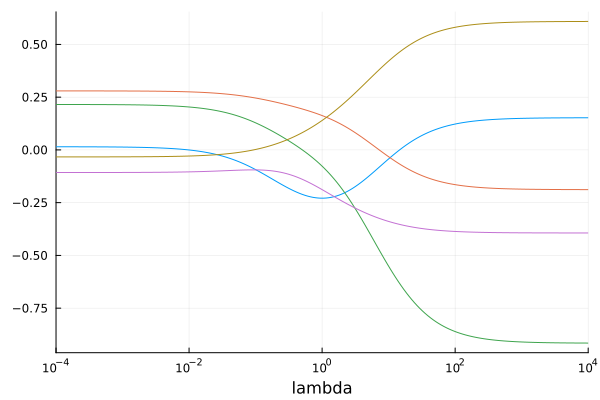

In [41]:
A1 = randn(10, 5)
A2 = randn(10, 5)
As = [A1, A2]

b1 = randn(10)
b2 = randn(10)
bs = [b1, b2]

N = 200
lambdas = 10 .^ linspace(-4, 4, N)
x = zeros(5, N)
J1 = zeros(N)
J2 = zeros(N)

for k=1:N 
    xhat = mols_solve(As, bs, [1 lambdas[k]])
    x[:, k] = xhat 
    J1[k] = norm(As[1]*xhat-bs[1])^2
    J2[k] = norm(As[2]*xhat-bs[2])^2
end

using Plots
plot(lambdas, x', xscale = :log10, xlabel="lambda", label="")
plot!(xlims=(1e-4, 1e4))

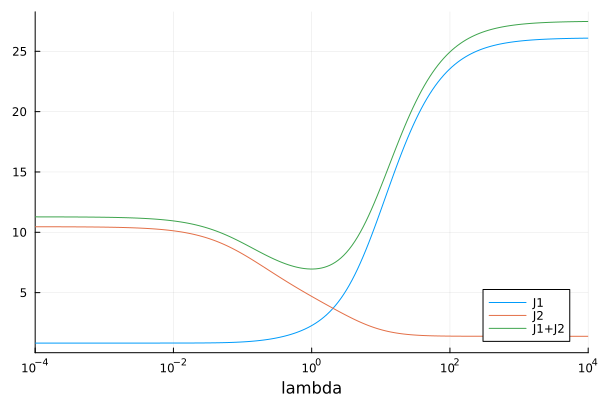

In [42]:
plot(lambdas, J1, xscale = :log10, label = "J1", xlabel = "lambda")
plot!(lambdas, J2, label = "J2", xlims=(1e-4, 1e4))
plot!(lambdas, J1+J2, label="J1+J2")

# plot trade-off curve

add (single objective) end points to trade off curve

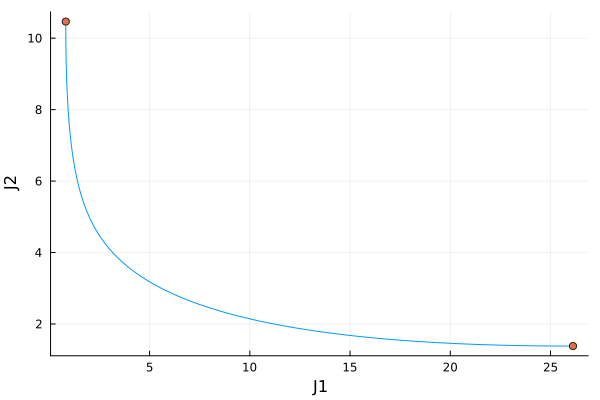

In [43]:
plot(J1, J2, xlabel="J1", ylabel="J2", legend=false)
x1 = As[1]\bs[1]
x2 = As[2]\bs[2]
J1_point = [norm(As[1]*x1-bs[1])^2, norm(As[1]*x2-bs[1])^2]
J2_point = [norm(As[2]*x1-bs[2])^2, norm(As[2]*x2-bs[2])^2]
scatter!(J1_point, J2_point)

# Estimation and inversion

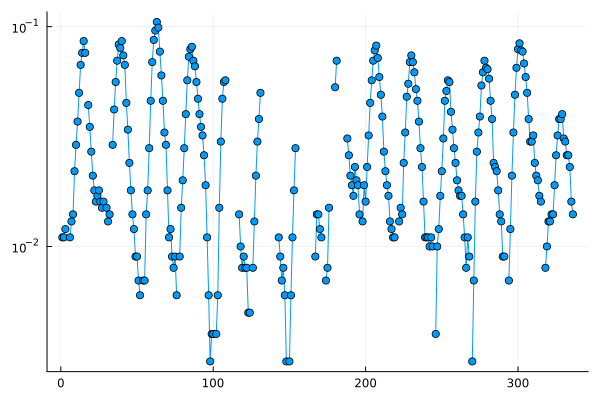

In [44]:
ozone = ozone_data()
k = 14
N = k*24
plot(1:N, ozone, yscale = :log10, marker = :circle, legend=false)

In [45]:
difference_matrix(n) = [-eye(n-1) zeros(n-1)] + [zeros(n-1) eye(n-1)]
difference_matrix(4)

3×4 Matrix{Float64}:
 -1.0   1.0   0.0  0.0
  0.0  -1.0   1.0  0.0
  0.0   0.0  -1.0  1.0

In [46]:
A = vcat([eye(24) for i=1:k]...)
D = [difference_matrix(24); [1; zeros(22); -1]']

24×24 Matrix{Float64}:
 -1.0   1.0   0.0   0.0   0.0   0.0  …   0.0   0.0   0.0   0.0   0.0   0.0
  0.0  -1.0   1.0   0.0   0.0   0.0      0.0   0.0   0.0   0.0   0.0   0.0
  0.0   0.0  -1.0   1.0   0.0   0.0      0.0   0.0   0.0   0.0   0.0   0.0
  0.0   0.0   0.0  -1.0   1.0   0.0      0.0   0.0   0.0   0.0   0.0   0.0
  0.0   0.0   0.0   0.0  -1.0   1.0      0.0   0.0   0.0   0.0   0.0   0.0
  0.0   0.0   0.0   0.0   0.0  -1.0  …   0.0   0.0   0.0   0.0   0.0   0.0
  0.0   0.0   0.0   0.0   0.0   0.0      0.0   0.0   0.0   0.0   0.0   0.0
  0.0   0.0   0.0   0.0   0.0   0.0      0.0   0.0   0.0   0.0   0.0   0.0
  0.0   0.0   0.0   0.0   0.0   0.0      0.0   0.0   0.0   0.0   0.0   0.0
  0.0   0.0   0.0   0.0   0.0   0.0      0.0   0.0   0.0   0.0   0.0   0.0
  ⋮                             ⋮    ⋱               ⋮                
  0.0   0.0   0.0   0.0   0.0   0.0  …   0.0   0.0   0.0   0.0   0.0   0.0
  0.0   0.0   0.0   0.0   0.0   0.0      0.0   0.0   0.0   0.0   0.0   0.0
  0.0 

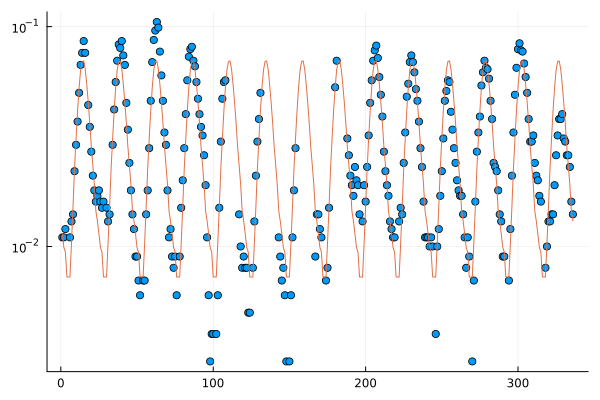

In [51]:
N = length(ozone)
ind = [k for k = 1:N if !isnan(ozone[k])]
Atil = [A[ind,:]; D]
ytil = [log.(ozone[ind]);zeros(24)]

x = Atil \ ytil
scatter(1:N, ozone, yscale = :log10, legend=false)
plot!(1:N, vcat([exp.(x) for i=1:k]...))


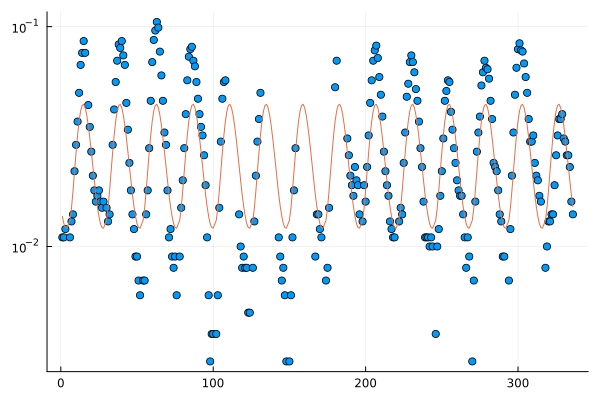

In [54]:
# find x(lambda)to minimize ||Ax - y||^2 + lambda*|| Dx ||^2
lambda = 100
Atil = [A[ind,:]; sqrt(lambda)*D]
x = Atil \ ytil

scatter(1:N, ozone, yscale = :log10, legend=false)
plot!(1:N, vcat([exp.(x) for i=1:k]...))

# Regularized data fitting 

We fit a model 

\begin{align}
\hat{f}(x) = \sum_{k=1}^5 \theta_kf_k(x)
\end{align}

with basis function $f_1(x) = 1, f_{k+1}(x) = sin(\omega_kx + \phi_k)$ for $k = 1, 2, 3, 4$

We fit the model by solving a sequence of regularized least squares problems with objective 

\begin{align}
J = ||y-A\theta||^2 + \lambda||\theta_{2:5}||^2
\end{align}

A is the coefficient matrix containing $f_k(x), k = 1,2,3,4,5$

In [7]:
function makeA(x, omega, phi)
    N = length(x)
    return [ones(N) sin.(x*omega' + ones(N)*phi')]
end

makeA (generic function with 1 method)

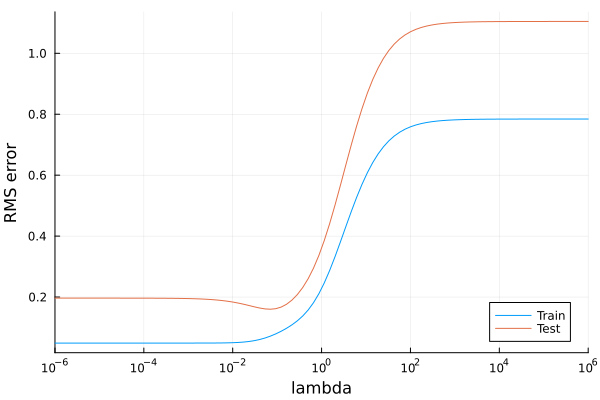

In [14]:
using LinearAlgebra
using VMLS 

D = regularized_fit_data()

x = D["xtrain"]
y = D["ytrain"]

xtest = D["xtest"]
ytest = D["ytest"]

N = length(y)
Ntest = length(ytest)

p = 5 
omega = [13.69; 3.55; 23.25; 6.03]
phi = [0.21; 0.02; -1.87; 1.72]

A = makeA(x, omega, phi)
Atest = makeA(xtest, omega, phi)
numLambdas = 100
lambdas = 10 .^ linspace(-6, 6, numLambdas)

train_errors = zeros(numLambdas)
test_errors = zeros(numLambdas)
Thetas = zeros(p, numLambdas)

for k = 1:numLambdas 
    A1 = A 
    A2 = [zeros(p-1) eye(p-1)]
    As = [A1, A2]
    bs = [y, zeros(p-1)]

    theta = mols_solve(As, bs, [1 lambdas[k]])
    Thetas[:, k] = theta 

    train_errors[k] = rms(y-A*theta)
    test_errors[k] = rms(ytest-Atest*theta)
end

using Plots 
plot(lambdas, train_errors, xscale = :log10, label="Train")
plot!(lambdas, test_errors, xscale = :log10, label="Test")
plot!(xlabel="lambda", ylabel = "RMS error", xlims=(1e-6, 1e6))